In [1]:
#0. CASO 5: CARGAR LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import shap

In [2]:
#1. CARGAR DE DATOS
df = pd.read_csv("caso5_marketing_conversion.csv")

In [3]:
df.head()

,duracion_video_seg,plataforma,segmento,likes,comentarios,conversion
0,46,Facebook,Adulto,524,91,0
1,90,Facebook,Senior,36,21,0
2,55,Facebook,Senior,588,198,0
3,77,Facebook,Senior,234,182,0
4,64,Facebook,Joven,970,161,0


In [4]:
df.describe()

,duracion_video_seg,likes,comentarios,conversion
count,220.000000,220.000000,220.000000,220.000000
mean,61.422727,472.377273,106.563636,0.204545
std,29.219504,277.239389,60.974510,0.404289
min,10.000000,5.000000,0.000000,0.000000
25%,39.000000,234.750000,51.000000,0.000000
50%,61.500000,467.000000,106.500000,0.000000
75%,88.000000,696.750000,164.250000,0.000000
max,115.000000,998.000000,199.000000,1.000000


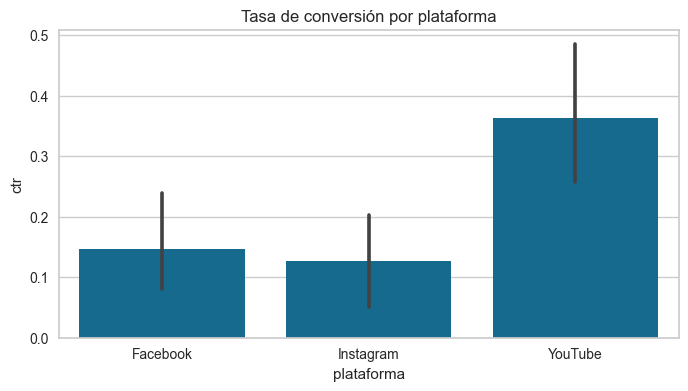

In [3]:
#2.ANALISIS EXPLORATORIO; CTR por plataforma
df['ctr']=df['conversion']
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='plataforma',y='ctr')
plt.title("Tasa de conversión por plataforma")
plt.show()

In [4]:
#3.FEATURE ENGINEERING: ENGAGEMENT COMBINADO
df['engagement'] = np.sqrt(df['likes']*0.7+df['comentarios']*1.5)

In [5]:
# Categorizar duración del video
df['duracion_categoria'] = pd.cut(
    df['duracion_video_seg'],
    bins=[0, 30, 60, 120],
    labels=['Corto', 'Medio', 'Largo']
)

In [6]:
# Crear variable combinada de canal y segmento
df['canal_segmento'] = df['plataforma'] + "_" + df['segmento']

In [7]:
#4.PYCARET: SETUP CON TÉNICAS AVANZADAS
clf = setup(
    data=df,
    target='conversion',
    session_id=2025,
    categorical_features=['plataforma', 'segmento', 'duracion_categoria', 'canal_segmento'],
    ignore_features=['ctr', 'duracion_video_seg'],
    normalize=True,
    feature_selection=False,
    remove_multicollinearity=False,
    transformation=True,
    transformation_method='yeo-johnson',
    verbose=False
)

In [8]:
# Comparar modelos automáticamente
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7925,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0350
gbc,Gradient Boosting Classifier,0.7912,0.7397,0.2833,0.3333,0.3038,0.2150,0.2129,0.0530
lr,Logistic Regression,0.7867,0.6374,0.2250,0.4233,0.2686,0.1843,0.2098,0.7280
ridge,Ridge Classifier,0.7800,0.6418,0.1583,0.3250,0.2019,0.1252,0.1415,0.0270
rf,Random Forest Classifier,0.7792,0.6916,0.1583,0.2500,0.1805,0.1092,0.1188,0.0710
lda,Linear Discriminant Analysis,0.7667,0.6470,0.2250,0.3733,0.2586,0.1545,0.1742,0.0320
knn,K Neighbors Classifier,0.7658,0.5474,0.1583,0.3500,0.2133,0.1074,0.1233,0.3310
ada,Ada Boost Classifier,0.7654,0.6864,0.3250,0.3600,0.3202,0.1997,0.2099,0.0470
lightgbm,Light Gradient Boosting Machine,0.7529,0.7479,0.2583,0.2900,0.2605,0.1330,0.1313,0.0810
svm,SVM - Linear Kernel,0.7412,0.6559,0.2250,0.2667,0.2356,0.1136,0.1144,0.0280


In [10]:
#CREAR MODELO
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8125,0.7708,0.5000,0.6667,0.5714,0.4545,0.4623
1,0.7500,0.5833,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8750,0.8718,0.6667,0.6667,0.6667,0.5897,0.5897
3,0.8750,0.9487,0.6667,0.6667,0.6667,0.5897,0.5897
4,0.8000,0.8889,0.3333,0.5000,0.4000,0.2857,0.2942
5,0.8000,0.7778,0.3333,0.5000,0.4000,0.2857,0.2942
6,0.8000,0.6389,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7333,0.5556,0.0000,0.0000,0.0000,-0.1111,-0.1336
8,0.7333,0.6667,0.3333,0.3333,0.3333,0.1667,0.1667


In [16]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8125,0.7708,0.5000,0.6667,0.5714,0.4545,0.4623
1,0.7500,0.5833,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8750,0.8718,0.6667,0.6667,0.6667,0.5897,0.5897
3,0.8750,0.9487,0.6667,0.6667,0.6667,0.5897,0.5897
4,0.8000,0.8889,0.3333,0.5000,0.4000,0.2857,0.2942
5,0.8000,0.7778,0.3333,0.5000,0.4000,0.2857,0.2942
6,0.8000,0.6389,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7333,0.5556,0.0000,0.0000,0.0000,-0.1111,-0.1336
8,0.7333,0.6667,0.3333,0.3333,0.3333,0.1667,0.1667


In [17]:
# 🔍 Interpretar con SHAP manualmente
X_train_transformed = get_config('X_train_transformed')
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(X_train_transformed)

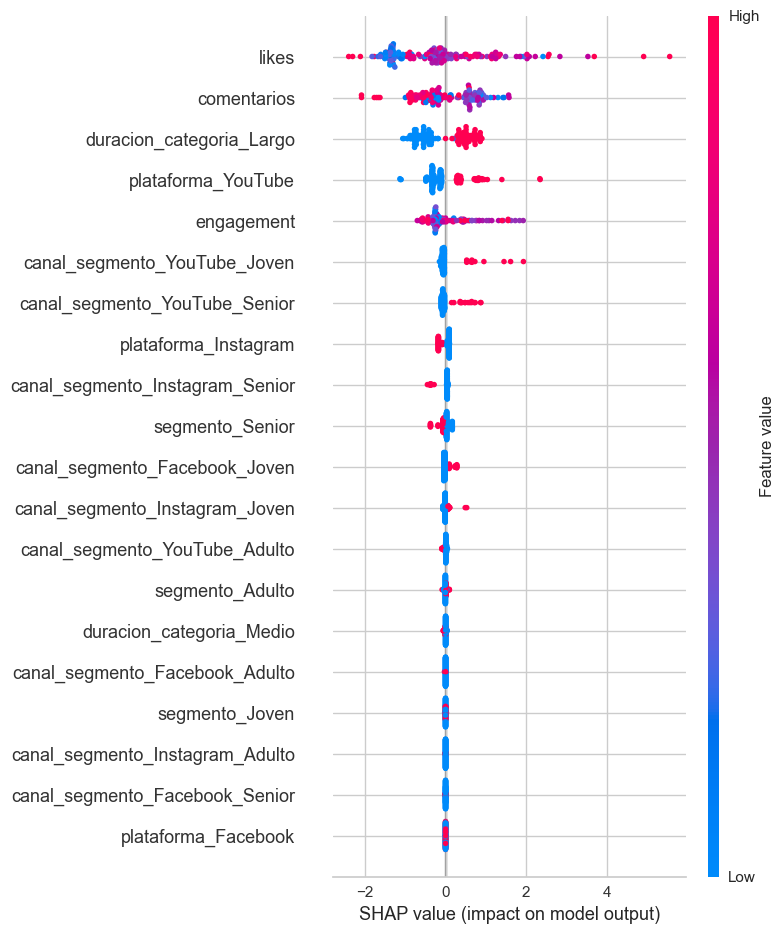

In [19]:
# Detectar si shap_values es una lista (por clase) o una matriz única
if isinstance(shap_values, list):
    # Modelo binario: usar la matriz de la clase positiva
    shap_matrix = shap_values[1]
else:
    # Modelo binario con una sola matriz
    shap_matrix = shap_values

# Ajustar si hay columna extra (offset)
if shap_matrix.shape[1] == X_train_transformed.shape[1] + 1:
    shap_values_fixed = shap_matrix[:, :-1]
else:
    shap_values_fixed = shap_matrix

# Alinear filas si hay desajuste
min_rows = min(shap_values_fixed.shape[0], X_train_transformed.shape[0])
shap.summary_plot(shap_values_fixed[:min_rows], X_train_transformed.iloc[:min_rows])